# Standard Model Testing

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
import h5py
from keras.optimizers import Adamax, Nadam
import sys
from writeNNet import saveNNet

from interval import interval, inf

from safe_train import propagate_interval, check_intervals, plot_policy

import matplotlib.pyplot as plt

# Options

In [12]:
ver = 4  # Neural network version
hu = 45  # Number of hidden units in each hidden layer in network
saveEvery = 3  # Epoch frequency of saving
totalEpochs = 20  # Total number of training epochs
BATCH_SIZE = 2**8
EPOCH_TO_PROJECT = 5
trainingDataFiles = (
    "../TrainingData/VertCAS_TrainingData_v2_%02d.h5"  # File format for training data
)
nnetFiles = (
    "../networks/SafeVertCAS_pra%02d_v%d_45HU_%03d.nnet"  # File format for .nnet files
)
advisories = {
    "COC": 0,
    "DNC": 1,
    "DND": 2,
    "DES1500": 3,
    "CL1500": 4,
    "SDES1500": 5,
    "SCL1500": 6,
    "SDES2500": 7,
    "SCL2500": 8,
}
# Constants
ra1 = (0.9, 0.9, 0.9)  # white
ra2 = (0.0, 1.0, 1.0)  # cyan
ra3 = (144.0 / 255.0, 238.0 / 255.0, 144.0 / 255.0)  # lightgreen
ra4 = (30.0 / 255.0, 144.0 / 255.0, 1.0)  # dodgerblue
ra5 = (0.0, 1.0, 0.0)  # lime
ra6 = (0.0, 0.0, 1.0)  # blue
ra7 = (34.0 / 255.0, 139.0 / 255.0, 34.0 / 255.0)  # forestgreen
ra8 = (0.0, 0.0, 128.0 / 255.0)  # navy
ra9 = (0.0, 100.0 / 255.0, 0.0)  # darkgreen
colors = [ra1, ra2, ra3, ra4, ra5, ra6, ra7, ra8, ra9]
bg_colors = [(1.0, 1.0, 1.0)]
action_names = [
    "COC",
    "DNC",
    "DND",
    "DES1500",
    "CL1500",
    "SDES1500",
    "SCL1500",
    "SDES2500",
    "SCL2500",
]

pra = 1

In [4]:
print("Loading Data for VertCAS, pra %02d, Network Version %d" % (pra, ver))
f = h5py.File(trainingDataFiles % pra, "r")
X_train = np.array(f["X"])
Q = np.array(f["y"])
means = np.array(f["means"])
ranges = np.array(f["ranges"])
min_inputs = np.array(f["min_inputs"])
max_inputs = np.array(f["max_inputs"])
print(f"min inputs: {min_inputs}")
print(f"max inputs: {max_inputs}")

N, numOut = Q.shape
print(f"Setting up model with {numOut} outputs and {N} training examples")
num_batches = N / BATCH_SIZE

# Asymmetric loss function
lossFactor = 40.0

# NOTE(nskh): from HorizontalCAS which was updated to use TF
def asymMSE(y_true, y_pred):
    d = y_true - y_pred
    maxes = tf.argmax(y_true, axis=1)
    maxes_onehot = tf.one_hot(maxes, numOut)
    others_onehot = maxes_onehot - 1
    d_opt = d * maxes_onehot
    d_sub = d * others_onehot
    a = lossFactor * (numOut - 1) * (tf.square(d_opt) + tf.abs(d_opt))
    b = tf.square(d_opt)
    c = lossFactor * (tf.square(d_sub) + tf.abs(d_sub))
    d = tf.square(d_sub)
    loss = tf.where(d_sub > 0, c, d) + tf.where(d_opt > 0, a, b)
    return tf.reduce_mean(loss)

Loading Data for VertCAS, pra 01, Network Version 4
min inputs: [-8000.  -100.  -100.     0.]
max inputs: [8000.  100.  100.   40.]
Setting up model with 9 outputs and 4053465 training examples


# Training: Standard

In [14]:
totalEpochs = 2
saveEvery = 1

use_sisl_colors = True

In [9]:
vo = 0
vi = 0

Metal device set to: Apple M1 Pro


2023-07-10 14:34:54.973655: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-10 14:34:54.973845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-10 14:34:55.277585: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-10 14:34:55.721626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15834/15834 [==============================] - 383s 24ms/step - loss: 0.1638 - accuracy: 0.9199
[interval([-51956.74101971148, 51306.61029839393]), interval([-63633.90343884378, 71348.3929916871]), interval([-70319.02049937655, 58034.37421189268]), interval([-61684.979685255305, 52031.049771053826]), interval([-79697.029614758, 54135.21688886722]), interval([-60433.33062388303, 39163.72664839304]), interval([-52176.20105868372, 36981.08810421842]), interval([-58909.00803946047, 47679.365737570704]), interval([-68389.30712204488, 38433.63431216583])]
 62/203 [========>.....................] - ETA: 0s

2023-07-10 14:41:18.166398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 1s 3ms/step


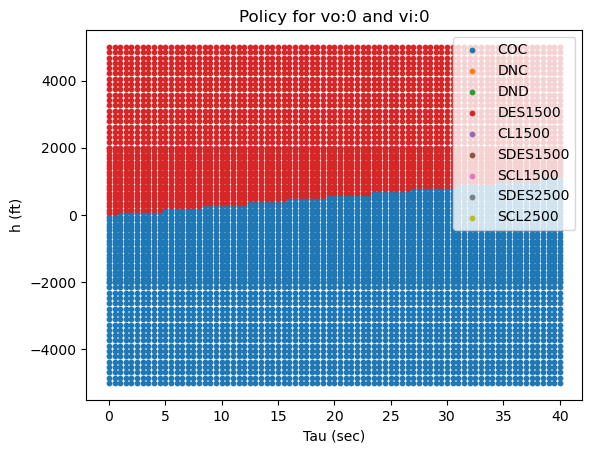

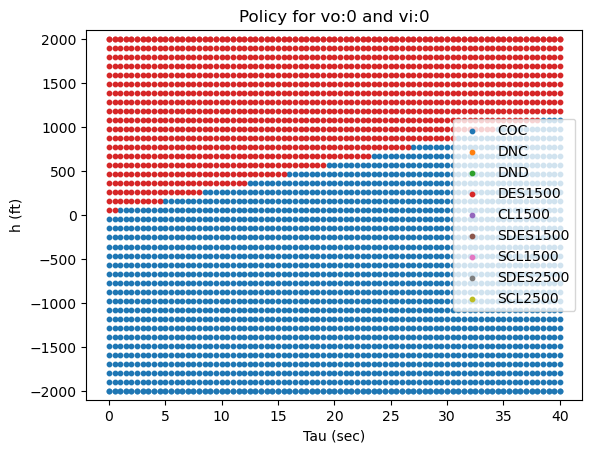

15834/15834 [==============================] - 386s 24ms/step - loss: 0.0501 - accuracy: 0.9536
[interval([-66801.3951453999, 63717.67652051718]), interval([-93635.33959475793, 99798.9992566453]), interval([-105727.33453538205, 86180.90068435625]), interval([-91886.11433986397, 61198.68161321706]), interval([-111421.72518020059, 80009.83185188092]), interval([-87561.95845793032, 42696.07025424934]), interval([-78073.97755887908, 53615.109732690355]), interval([-87620.57390994344, 57180.542279232686]), interval([-94157.79999213644, 56090.6079781672])]
203/203 [==============================] - 1s 2ms/step


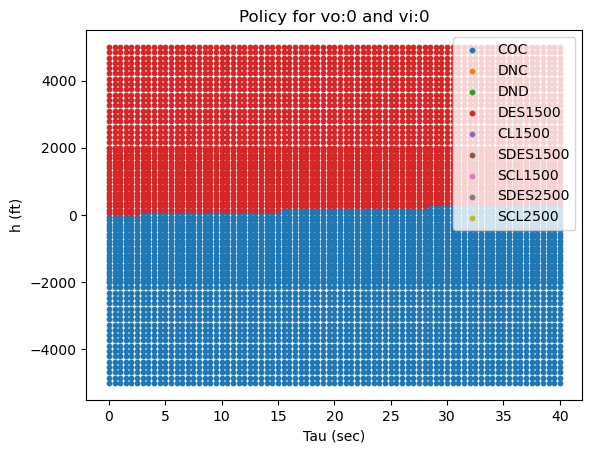

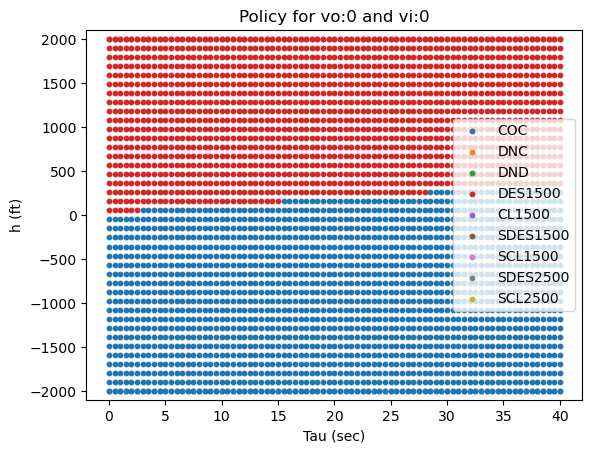

In [10]:
# Define model architecture
model = Sequential()
# model.add(Dense(hu, init='uniform', activation='relu', input_dim=4))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
# model.add(Dense(hu, init='uniform', activation='relu'))
model.add(Dense(hu, activation="relu", input_dim=4))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))
model.add(Dense(hu, activation="relu"))

# model.add(Dense(numOut, init="uniform"))
model.add(Dense(numOut))
opt = Nadam(learning_rate=0.0003)
model.compile(loss=asymMSE, optimizer=opt, metrics=["accuracy"])

# # Train and write nnet files
epoch = saveEvery
while epoch <= totalEpochs:
    model.fit(X_train, Q, epochs=saveEvery, batch_size=2**8, shuffle=True)
    saveFile = nnetFiles % (pra, ver, epoch)
    saveNNet(model, saveFile, means, ranges, min_inputs, max_inputs)
    epoch += saveEvery
    output_interval, penultimate_interval = propagate_interval(
        [
            interval[400, 500],
            interval[50, 51],
            interval[-51, -50],
            interval[20, 21],
        ],
        model,
        graph=False,
    )
    print(output_interval)
    plot_policy(model, f"images/standard_vcas_policy_viz_vo50_vi-50_epoch{epoch}.pdf", zoom=True)

203/203 [==============================] - 1s 3ms/step


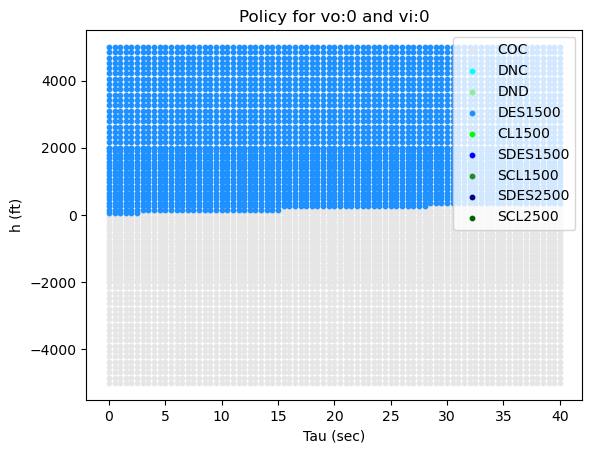

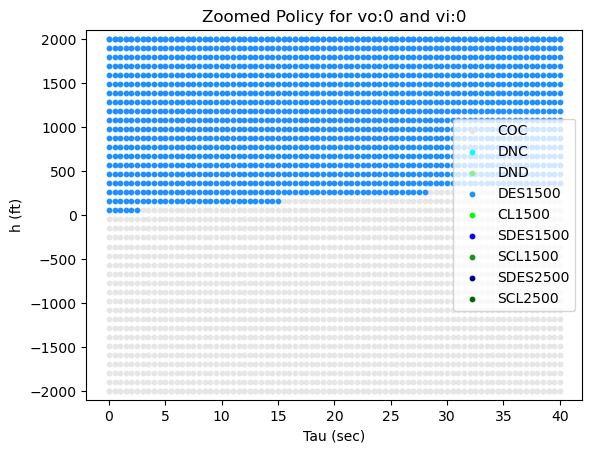

In [16]:
x_grid = None
taus = np.linspace(0, 40, 81)
hs = np.hstack(
    [
        np.linspace(-5000, -2000, 20),
        np.linspace(-2000, 2000, 40),
        np.linspace(2000, 5000, 20),
    ]
)
for tau in taus:
    grid_component = np.vstack(
        [
            hs,
            np.ones(hs.shape) * vo,
            np.ones(hs.shape) * vi,
            np.ones(hs.shape) * tau,
        ]
    ).T
    if x_grid is not None:
        x_grid = np.vstack([x_grid, grid_component])
    else:
        x_grid = grid_component

y_pred = model.predict(x_grid)
advisory_idxs = np.argmax(y_pred, axis=1)

# dict indexed by color/advisory of all points
xs = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
ys = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

for i, advisory_idx in enumerate(advisory_idxs):
    scatter_x = x_grid[i, 3]  # tau
    scatter_y = x_grid[i, 0]  # h
    xs[advisory_idx].append(scatter_x)
    ys[advisory_idx].append(scatter_y)

plt.figure()
plt.tight_layout()
for i in range(len(colors)):
    if use_sisl_colors:
        plt.scatter(xs[i], ys[i], s=10, c=[colors[i]])
    else:
        plt.scatter(xs[i], ys[i], s=10)
plt.legend(action_names)
plt.xlabel("Tau (sec)")
plt.ylabel("h (ft)")
plt.title(f"Policy for vo:{vo} and vi:{vi}")
plt.show()

plt.figure()
plt.tight_layout()
for i in range(len(colors)):
    if use_sisl_colors:
        plt.scatter(xs[i], ys[i], s=10, c=[colors[i]])
    else:
        plt.scatter(xs[i], ys[i], s=10)
plt.legend(action_names)
plt.xlabel("Tau (sec)")
plt.ylabel("h (ft)")
plt.title(f"Zoomed Policy for vo:{vo} and vi:{vi}")
plt.ylim([-2100, 2100])
plt.show()


In [20]:
# Print out some advisories at a few sample points
advisory_indices = np.argmax(
    model.predict(
        np.array(
            [
                [200, 0, 0, 12],
                [0, 0, 0, 10],
                [-200, 0, 0, 20],
                [-400, 0, 0, 2],
                [400, 0, 0, 2],
                [400, 0, 0, 4],
                [400, 0, 0, 6],
                [400, 0, 0, 8],
                [-400, 0, 0, 2],
                [-400, 0, 0, 4],
                [-400, 0, 0, 6],
                [-400, 0, 0, 8],
            ]
        )
    ),
    axis=1,
)
print([action_names[idx] for idx in advisory_indices])

1/1 [==============================] - 0s 176ms/step
['DES1500', 'COC', 'COC', 'COC', 'DES1500', 'DES1500', 'DES1500', 'DES1500', 'COC', 'COC', 'COC', 'COC']
